# Examen Final - Temas Avanzados en Computación
##### Integrantes:
* 20110324        Zorrilla Maguiña, Louis Javier
* 20154373	      Ormeño Meza, Ruben Aaron
* 20160236	      Ulloa Coronado, Adrian Eduardo

In [1]:
from PIL import Image
import PIL
import glob
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
from imgaug import augmenters as iaa
import imgaug as ia
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import warnings

In [2]:
root = '/home/ubuntu/tac/Mi3_Aligned'
class MiDataset(torch.utils.data.Dataset):
  def __init__(self, root, tform=None, imgloader=Image.open, set_type='train'):
    super(MiDataset, self).__init__()
    
    self.root = root
    if set_type=='train':
        self.filenames = sorted(glob.glob(root + '/*/*Reference0[0-9].jpg'))
    elif set_type=='target':
        self.filenames = sorted(glob.glob(root + '/*/*Noisy0[0-9].jpg'))
    elif set_type=='test':
        self.filenames = sorted(glob.glob(root + '/*/*Noisy1[0-9].jpg'))
            
    self.tform = tform
    self.imgloader = imgloader
    
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self, i):
    out = self.imgloader(self.filenames[i])
    if self.tform:
      out = self.tform(out)
    return out

doc_train_dataset = MiDataset(root=root,tform=T.Compose([T.ToTensor()]), set_type='train')
doc_train_loader = torch.utils.data.DataLoader(doc_train_dataset, batch_size=4)

doc_target_dataset = MiDataset(root=root,  tform=T.Compose([T.ToTensor()]), set_type='target')
doc_target_loader = torch.utils.data.DataLoader(doc_target_dataset, batch_size=4)

doc_test_dataset = MiDataset(root=root,   tform=T.Compose([T.ToTensor()]), set_type='test')
doc_test_loader = torch.utils.data.DataLoader(doc_target_dataset, batch_size=4)

In [3]:
len(doc_train_dataset)

400

In [5]:
class NoiseRemoval(nn.Module):
  def __init__(self):
    super(NoiseRemoval, self).__init__()
    
    self.encoder = nn.Sequential(nn.Conv2d(3, 250, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(2, 2))
    
    self.decoder = nn.Sequential(nn.Conv2d(250, 250, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(250, 3, kernel_size=3, padding=1))
    
  def forward(self,x):
    return self.decoder(self.encoder(x))
  
net = NoiseRemoval()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

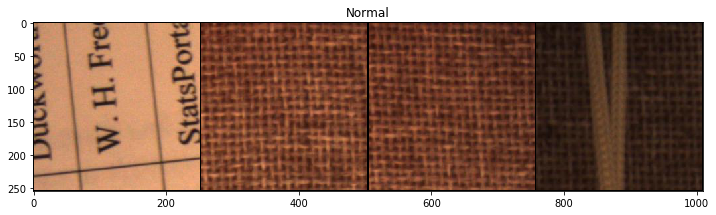

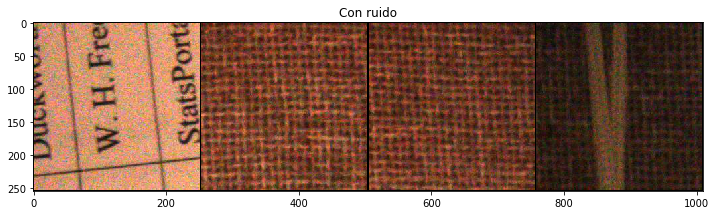

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


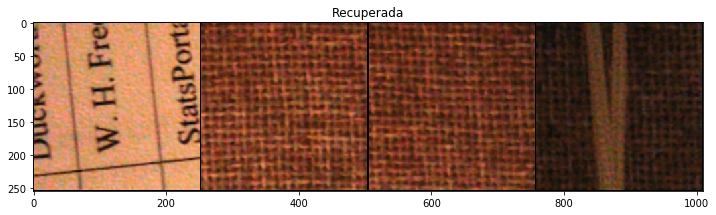

In [6]:
net = torch.load('/home/ubuntu/tac/modelo1.torch')

data = next(iter(doc_test_loader))

with torch.no_grad():
  out = net(data)

grid1 = torchvision.utils.make_grid(data, nrow=4)
grid2 = torchvision.utils.make_grid(out.cpu(), nrow=4)
gridX = torchvision.utils.make_grid(next(iter(doc_train_loader)), nrow=4)

plt.figure(figsize=(12, 12))
plt.imshow(gridX.permute(1, 2, 0))
plt.title('Normal')
plt.show()

plt.figure(figsize=(12, 12))
plt.imshow(grid1.permute(1, 2, 0))
plt.title('Con ruido')
plt.show()

plt.figure(figsize=(12, 12))
plt.imshow(grid2.permute(1, 2, 0))
plt.title('Recuperada')
plt.show()